# Convolutional Neural Networks Model Analysis

### Importing Libraries

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

# Impoerting data processing functions
import ipynb.fs.full.Data_Processing as process

# Early Stopping Class

In [7]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()

        elif score > self.best_score:
            self.counter += 1
            
            if self.counter >= self.patience:
                self.early_stop = True
                
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def reset(self):
        self.__init__()

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

# Initial Classifier Architecture

In [8]:
macbook = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [9]:
# Model Architecture
class ImageClassifier_1(nn.Module):
    def __init__(self):
        super(ImageClassifier_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, 
                            stride=1, padding=0)
        self.ReLU = nn.ReLU()
        self.MaxPool = nn.MaxPool2d(2,1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,
                            stride=1, padding=0)
        self.Flatten = nn.Flatten()
        self.Linear1 = nn.Linear(in_features=21632, out_features=512)
        self.Linear2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, X):
        X = self.MaxPool(self.ReLU(self.conv1(X))) # First Convolution Layer
        X = self.MaxPool(self.ReLU(self.conv2(X))) # Second Convolution layer
        X = self.ReLU(self.Linear1(self.Flatten(X))) # First Linear Layer
        X = self.Linear2(X) # Second Linear Layer
        return X
    
model = ImageClassifier_1()
model.to(macbook)

ImageClassifier_1(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (ReLU): ReLU()
  (MaxPool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear1): Linear(in_features=21632, out_features=512, bias=True)
  (Linear2): Linear(in_features=512, out_features=10, bias=True)
)

# Training Functions

In [10]:
# Initializing dummy variables
optimizer = optim.Adam(model.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()

# Loading dummy data
train_loader, val_loader, test_loader = process.data_pipeline(batch_size=64, transform_func=process.transformations)

Files already downloaded and verified
Files already downloaded and verified


### Training Function

In [11]:
# Training Function
def train_epoch(progress_bar):

    loss = 0
    accuracy = 0
    samples = 0

    for X, Y in progress_bar:
        X, Y = X.to(macbook), Y.to(macbook)
        optimizer.zero_grad() 
        size = Y.size(0)
        pred=model(X)
        batch_loss=criterion(pred, Y)
        batch_loss.backward()
        optimizer.step()
        loss+=batch_loss.item()*size
        accuracy += (torch.argmax(pred, dim=1) == Y).sum().item()
        samples += size
        progress_bar.set_postfix()
    
    avg_loss= loss/samples
    percent = accuracy/samples*100
    print(f'    Average Training Loss: {avg_loss:.4f}')
    print(f'    Training Accuracy: {percent:.2f}%')
    return avg_loss, percent

### Validation function

In [12]:
def validation():

    loss = 0
    accuracy = 0
    samples = 0

    with torch.no_grad():
        for X,Y in val_loader:
            X, Y = X.to(macbook), Y.to(macbook)
            size = Y.size(0)
            pred = model(X)
            batch_loss = criterion(pred, Y)
            loss+=batch_loss.item()*size
            accuracy += (torch.argmax(pred, dim=1) == Y).sum().item()
            samples += size
    
    avg_loss = loss/samples
    percent = accuracy/samples*100
    print(f'    Average Validation Loss: {avg_loss:.4f}')
    print(f'    Validation Accuracy: {percent:.2f}%')
    return avg_loss, percent

### Test Function

In [13]:
def accuracy():
    
    model.eval()
    accuracy = 0
    samples = 0

    with torch.no_grad():
        for X,Y in test_loader:
            X, Y = X.to(macbook), Y.to(macbook)
            size = Y.size(0)
            pred = model(X)
            accuracy += (torch.argmax(pred, dim=1) == Y).sum().item()
            samples += size
    
    percent = accuracy/samples * 100
    print(f"The Model Accuracy (utilizing the test set) is of {percent:.2f}%")
    return(percent)

### Training loop

In [14]:
def train_model(num_epochs):

    # Initializing Vectors to store variables
    t_loss = np.zeros(num_epochs+1)
    v_loss = np.zeros(num_epochs+1)
    t_accuracy = np.zeros(num_epochs+1)
    v_accuracy = np.zeros(num_epochs+1)
    
    # For loop for Epochs
    for epoch in range(num_epochs):

        # Training one Epoch
        model.train(True)
        progress_bar = tqdm(train_loader, desc=f"EPOCH {epoch+1}")
        t_loss[epoch], t_accuracy[epoch] = train_epoch(progress_bar)

        # Validation
        model.eval()
        v_loss[epoch], v_accuracy[epoch] = validation()

        # Early Stopping 
        early_stopping(v_loss[epoch], model)
        print('')
        if early_stopping.early_stop: 
            print("Early Stop Enacted")
            t_loss=t_loss[:1+epoch]
            v_loss=v_loss[:1+epoch]
            t_accuracy=t_accuracy[:1+epoch]
            v_accuracy=v_accuracy[:1+epoch]
            break

    # Loading Best Model and Final Line
    early_stopping.load_best_model(model)
    return t_loss, v_loss, t_accuracy, v_accuracy

# Initial Classifier

### Model Training

In [15]:
# Loading Model
model = ImageClassifier_1()
model.to(macbook)


# Hyper-Paramaters
max_epochs = 30
learning_rate = .001

# Initializing classes and functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=5)

# Loading Data
train_loader, val_loader, test_loader = process.data_pipeline(batch_size=64, transform_func=process.transformations)

# Training
t_loss, v_loss, t_accuracy, v_accuracy = train_model(max_epochs)

Files already downloaded and verified
Files already downloaded and verified


EPOCH 1: 100%|██████████| 625/625 [00:16<00:00, 38.91it/s]


    Average Training Loss: 2.0994
    Training Accuracy: 23.44%
    Average Validation Loss: 1.9613
    Validation Accuracy: 29.64%



EPOCH 2: 100%|██████████| 625/625 [00:15<00:00, 39.97it/s]


    Average Training Loss: 1.8911
    Training Accuracy: 32.37%
    Average Validation Loss: 1.7906
    Validation Accuracy: 36.90%



EPOCH 3: 100%|██████████| 625/625 [00:16<00:00, 38.82it/s]


    Average Training Loss: 1.7553
    Training Accuracy: 37.48%
    Average Validation Loss: 1.6496
    Validation Accuracy: 41.21%



EPOCH 4: 100%|██████████| 625/625 [00:15<00:00, 39.68it/s]


    Average Training Loss: 1.6222
    Training Accuracy: 42.36%
    Average Validation Loss: 1.6035
    Validation Accuracy: 42.76%



EPOCH 5: 100%|██████████| 625/625 [00:15<00:00, 39.14it/s]


    Average Training Loss: 1.5309
    Training Accuracy: 45.99%
    Average Validation Loss: 1.5719
    Validation Accuracy: 44.75%



EPOCH 6: 100%|██████████| 625/625 [00:15<00:00, 39.32it/s]


    Average Training Loss: 1.4618
    Training Accuracy: 48.19%
    Average Validation Loss: 1.5330
    Validation Accuracy: 46.44%



EPOCH 7: 100%|██████████| 625/625 [00:15<00:00, 39.27it/s]


    Average Training Loss: 1.4031
    Training Accuracy: 50.60%
    Average Validation Loss: 1.5161
    Validation Accuracy: 46.90%



EPOCH 8: 100%|██████████| 625/625 [00:16<00:00, 38.92it/s]


    Average Training Loss: 1.3493
    Training Accuracy: 52.73%
    Average Validation Loss: 1.5546
    Validation Accuracy: 46.37%



EPOCH 9: 100%|██████████| 625/625 [00:16<00:00, 38.28it/s]


    Average Training Loss: 1.2952
    Training Accuracy: 54.84%
    Average Validation Loss: 1.5320
    Validation Accuracy: 47.43%



EPOCH 10: 100%|██████████| 625/625 [00:16<00:00, 38.31it/s]


    Average Training Loss: 1.2325
    Training Accuracy: 56.80%
    Average Validation Loss: 1.5496
    Validation Accuracy: 47.46%



EPOCH 11: 100%|██████████| 625/625 [00:16<00:00, 38.84it/s]


    Average Training Loss: 1.1841
    Training Accuracy: 58.66%
    Average Validation Loss: 1.5447
    Validation Accuracy: 47.95%



EPOCH 12: 100%|██████████| 625/625 [00:16<00:00, 38.47it/s]


    Average Training Loss: 1.1360
    Training Accuracy: 60.57%
    Average Validation Loss: 1.5656
    Validation Accuracy: 47.49%

Early Stop Enacted


### Model 1 Results

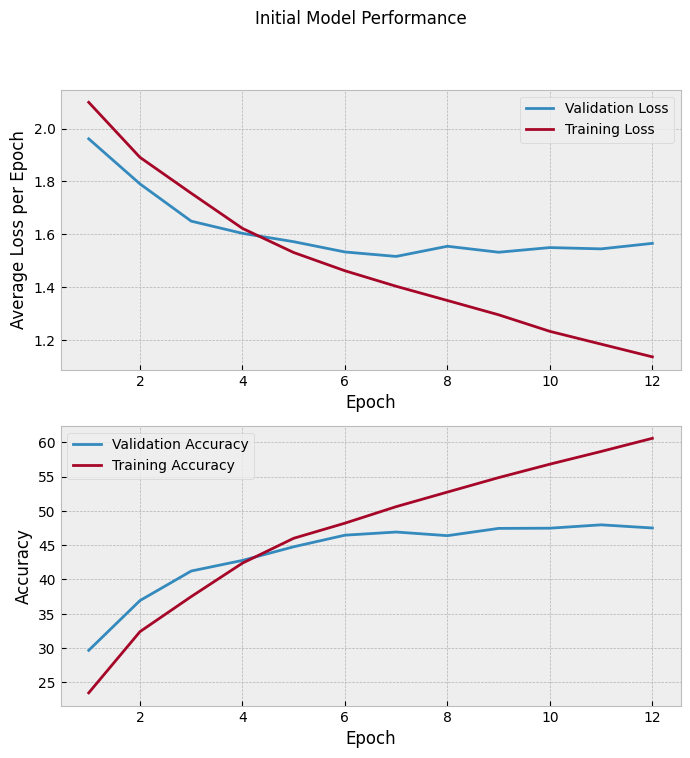

The Model Accuracy (utilizing the test set) is of 46.67%


In [17]:
# Plotting the Figure
fig, ax = plt.subplots(2, figsize=(8, 8))
fig.suptitle("Initial Model Performance")

ax[0].plot(range(1,len(v_loss)+1), v_loss, label="Validation Loss", linestyle="-")
ax[0].plot(range(1,len(t_loss)+1), t_loss, label="Training Loss", linestyle="-")

ax[0].set_ylabel("Average Loss per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(range(1,len(v_accuracy)+1), v_accuracy, label="Validation Accuracy", linestyle="-")
ax[1].plot(range(1,len(t_accuracy)+1), t_accuracy, label="Training Accuracy", linestyle="-")

ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.style.use('bmh')
plt.show()

model1_acc = accuracy()

# Increasing Depth

### Deep Model Architecture

In [35]:
# Creation of the Increased Model Depth
class ImageClassifier_2(nn.Module):
    def __init__(self):
        super(ImageClassifier_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.ReLU = nn.ReLU()
        self.MaxPool = nn.MaxPool2d(2,1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.Flatten = nn.Flatten()
        self.Linear1 = nn.Linear(in_features=64*400, out_features=512)
        self.Linear2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, X):
        X = self.MaxPool(self.ReLU(self.conv1(X)))  # First Convolution Layer
        X = self.MaxPool(self.ReLU(self.conv2(X)))  # Second Convolution layer
        X = self.MaxPool(self.ReLU(self.conv3(X)))  # Third Convolution Layer
        X = self.MaxPool(self.ReLU(self.conv4(X)))  # Third Convolution Layer
        X = self.Linear1(self.Flatten(X))           # First Linear Layer
        X = self.Linear2(self.ReLU(X))              # Second Linear Layer
        return X
    
model = ImageClassifier_2()
model.to(macbook)

ImageClassifier_2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (ReLU): ReLU()
  (MaxPool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear1): Linear(in_features=25600, out_features=512, bias=True)
  (Linear2): Linear(in_features=512, out_features=10, bias=True)
)

### Parameters and Training

In [36]:
max_epochs = 30
learning_rate = .001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=5)

# Loading Data
train_loader, val_loader, test_loader = process.data_pipeline(batch_size=64, transform_func=process.transformations)

# Training
t_loss2, v_loss2, t_accuracy2, v_accuracy2 = train_model(max_epochs)

Files already downloaded and verified
Files already downloaded and verified


/Users/maxb/myenv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
EPOCH 1: 100%|██████████| 625/625 [00:19<00:00, 32.78it/s]


    Average Training Loss: 2.1278
    Training Accuracy: 21.34%
    Average Validation Loss: 2.0738
    Validation Accuracy: 23.87%



EPOCH 2: 100%|██████████| 625/625 [00:18<00:00, 32.90it/s]


    Average Training Loss: 1.8990
    Training Accuracy: 31.23%
    Average Validation Loss: 1.7599
    Validation Accuracy: 36.77%



EPOCH 3: 100%|██████████| 625/625 [00:19<00:00, 32.88it/s]


    Average Training Loss: 1.7228
    Training Accuracy: 38.25%
    Average Validation Loss: 1.6314
    Validation Accuracy: 41.46%



EPOCH 4: 100%|██████████| 625/625 [00:18<00:00, 33.29it/s]


    Average Training Loss: 1.6236
    Training Accuracy: 41.84%
    Average Validation Loss: 1.5660
    Validation Accuracy: 44.20%



EPOCH 5: 100%|██████████| 625/625 [00:18<00:00, 32.95it/s]


    Average Training Loss: 1.5398
    Training Accuracy: 45.21%
    Average Validation Loss: 1.5340
    Validation Accuracy: 45.68%



EPOCH 6: 100%|██████████| 625/625 [00:18<00:00, 33.19it/s]


    Average Training Loss: 1.4812
    Training Accuracy: 47.41%
    Average Validation Loss: 1.5135
    Validation Accuracy: 46.77%



EPOCH 7: 100%|██████████| 625/625 [00:18<00:00, 33.38it/s]


    Average Training Loss: 1.4360
    Training Accuracy: 49.37%
    Average Validation Loss: 1.4987
    Validation Accuracy: 46.85%



EPOCH 8: 100%|██████████| 625/625 [00:18<00:00, 33.39it/s]


    Average Training Loss: 1.3856
    Training Accuracy: 50.88%
    Average Validation Loss: 1.4202
    Validation Accuracy: 50.03%



EPOCH 9: 100%|██████████| 625/625 [00:19<00:00, 32.86it/s]


    Average Training Loss: 1.3417
    Training Accuracy: 52.76%
    Average Validation Loss: 1.4288
    Validation Accuracy: 49.73%



EPOCH 10: 100%|██████████| 625/625 [00:18<00:00, 33.07it/s]


    Average Training Loss: 1.2984
    Training Accuracy: 54.07%
    Average Validation Loss: 1.4208
    Validation Accuracy: 50.32%



EPOCH 11: 100%|██████████| 625/625 [00:18<00:00, 33.17it/s]


    Average Training Loss: 1.2601
    Training Accuracy: 55.53%
    Average Validation Loss: 1.4565
    Validation Accuracy: 49.66%



EPOCH 12: 100%|██████████| 625/625 [00:18<00:00, 32.91it/s]


    Average Training Loss: 1.2201
    Training Accuracy: 57.08%
    Average Validation Loss: 1.4133
    Validation Accuracy: 50.96%



EPOCH 13: 100%|██████████| 625/625 [00:18<00:00, 33.06it/s]


    Average Training Loss: 1.1906
    Training Accuracy: 58.46%
    Average Validation Loss: 1.4382
    Validation Accuracy: 51.24%



EPOCH 14: 100%|██████████| 625/625 [00:18<00:00, 33.18it/s]


    Average Training Loss: 1.1528
    Training Accuracy: 59.64%
    Average Validation Loss: 1.4346
    Validation Accuracy: 50.22%



EPOCH 15: 100%|██████████| 625/625 [00:18<00:00, 33.10it/s]


    Average Training Loss: 1.1180
    Training Accuracy: 60.70%
    Average Validation Loss: 1.4638
    Validation Accuracy: 50.83%



EPOCH 16: 100%|██████████| 625/625 [00:18<00:00, 33.62it/s]


    Average Training Loss: 1.0911
    Training Accuracy: 61.94%
    Average Validation Loss: 1.4720
    Validation Accuracy: 50.61%



EPOCH 17: 100%|██████████| 625/625 [00:18<00:00, 33.61it/s]


    Average Training Loss: 1.0533
    Training Accuracy: 63.37%
    Average Validation Loss: 1.4701
    Validation Accuracy: 51.19%

Early Stop Enacted


The Model Accuracy (utilizing the test set) is of 50.10%


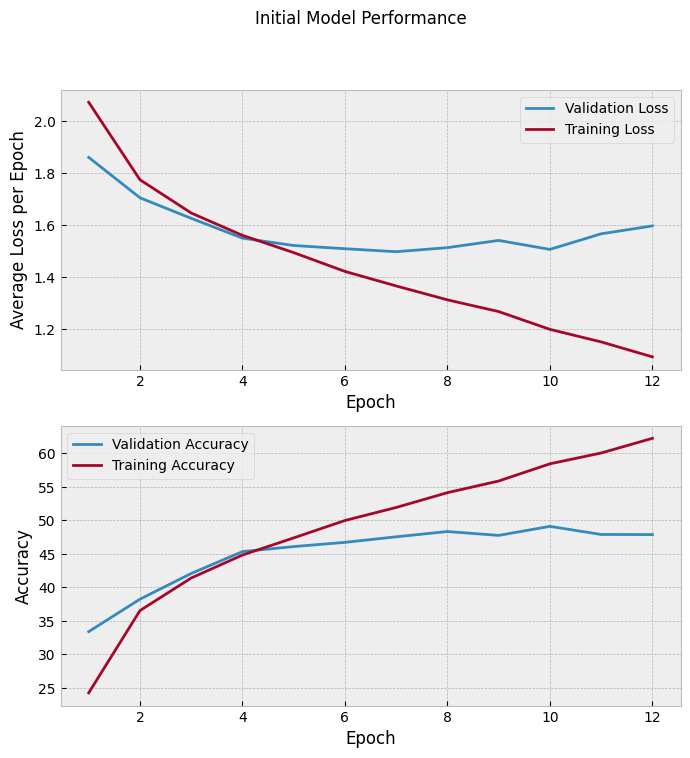

In [37]:
model2_acc = accuracy()

# Plotting the Figure
fig, ax = plt.subplots(2, figsize=(8, 8))
fig.suptitle("Initial Model Performance")

ax[0].plot(range(1,len(v_loss)+1), v_loss, label="Validation Loss", linestyle="-")
ax[0].plot(range(1,len(t_loss)+1), t_loss, label="Training Loss", linestyle="-")

ax[0].set_ylabel("Average Loss per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].plot(range(1,len(v_accuracy)+1), v_accuracy, label="Validation Accuracy", linestyle="-")
ax[1].plot(range(1,len(t_accuracy)+1), t_accuracy, label="Training Accuracy", linestyle="-")

ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.style.use('bmh')
plt.show()

# Batch Normalization Model

### Batch-Norm Atchitecture

In [38]:
class ImageClassifier_3(nn.Module):
    def __init__(self):
        super(ImageClassifier_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.ReLU = nn.ReLU()
        self.MaxPool = nn.MaxPool2d(2,1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.Batch32 = nn.BatchNorm2d(32)
        self.Batch64 = nn.BatchNorm2d(64)
        self.Flatten = nn.Flatten()
        self.Linear1 = nn.Linear(in_features=64*400, out_features=512)
        self.Linear2 = nn.Linear(in_features=512, out_features=10)

    def forward(self, X):
        X = self.MaxPool(self.ReLU(self.conv1(X)))                # First Convolution Layer
        X = self.Batch32(X)                                       # Batch Normalization
        X = self.MaxPool(self.ReLU(self.conv2(X)))                # Second Convolution layer
        X = self.Batch32(X)                                       # Batch Normalization
        X = self.MaxPool(self.ReLU(self.conv3(X)))                # Third Convolution Layer
        X = self.Batch64(X)                                       # Batch Normalization
        X = self.MaxPool(self.ReLU(self.conv4(X)))                # Third Convolution Layer
        X = self.Batch64(X)                                       # Batch Normalization
        X = self.Linear1(self.Flatten(X))                         # First Linear Layer
        X = self.Linear2(self.ReLU(X))                            # Second Linear Layer
        return X
    
model = ImageClassifier_3()
model.to(macbook)

ImageClassifier_3(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (ReLU): ReLU()
  (MaxPool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (Batch32): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Batch64): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear1): Linear(in_features=25600, out_features=512, bias=True)
  (Linear2): Linear(in_features=512, out_features=10, bias=True)
)

### Parameters and Training

In [39]:
max_epochs = 30
learning_rate = .001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=5)

# Loading Data
train_loader, val_loader, test_loader = process.data_pipeline(batch_size=64, transform_func=process.transformations)

# Training
t_loss3, v_loss3, t_accuracy3, v_accuracy3 = train_model(max_epochs)

Files already downloaded and verified
Files already downloaded and verified


/Users/maxb/myenv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
EPOCH 1: 100%|██████████| 625/625 [00:19<00:00, 31.39it/s]


    Average Training Loss: 2.0499
    Training Accuracy: 31.37%
    Average Validation Loss: 2.7210
    Validation Accuracy: 12.84%



EPOCH 2: 100%|██████████| 625/625 [00:18<00:00, 34.24it/s]


    Average Training Loss: 1.6522
    Training Accuracy: 40.92%
    Average Validation Loss: 6.7494
    Validation Accuracy: 10.02%



EPOCH 3: 100%|██████████| 625/625 [00:18<00:00, 33.92it/s]


    Average Training Loss: 1.5304
    Training Accuracy: 45.68%
    Average Validation Loss: 5.9011
    Validation Accuracy: 9.94%



EPOCH 4: 100%|██████████| 625/625 [00:18<00:00, 33.70it/s]


    Average Training Loss: 1.4335
    Training Accuracy: 49.41%
    Average Validation Loss: 7.1080
    Validation Accuracy: 10.81%



EPOCH 5: 100%|██████████| 625/625 [00:18<00:00, 33.64it/s]


    Average Training Loss: 1.3498
    Training Accuracy: 52.31%
    Average Validation Loss: 6.6973
    Validation Accuracy: 14.71%



EPOCH 6: 100%|██████████| 625/625 [00:18<00:00, 33.34it/s]


    Average Training Loss: 1.2692
    Training Accuracy: 55.16%
    Average Validation Loss: 10.7919
    Validation Accuracy: 12.40%

Early Stop Enacted
